<a href="https://colab.research.google.com/github/jamesnjoro/tweetAnalyzer/blob/main/KPLC%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweets analyzer.

#### This Notebook analyzes tweets to from individuals to a company. The please note:
##### 1. The main goal of this notebook is to analyze questions and reviews left by users for company's therefore to get more relevant data I have excluded tweets with attachments and only included tweets which are not replies to tweets or retweets.

#### 2. The data has been scrapped from twitter directly using octoparse 8. This data is from the periods between 01/01/2021 to 31/12/2021.

In [161]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install spacy-langdetect
!pip install contractions
!pip install gensim
!pip install pyLDAvis

import pandas as pd
import regex as re
import plotly.express as px
import numpy as np
import datetime
import spacy
import nltk
import contractions
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.enable_notebook()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

     |████████████████████████████████| 12.0 MB 8.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [162]:
df = pd.read_csv('/content/kplc_twitter_2021.csv')

In [163]:
def convertCountToInt(count):
    if(isinstance(count,str) and count[-1].lower() in ['k','m']):
        multiplier = 1000  if count[-1].lower() == 'k' else 1000000
        count = float(count[:len(count)-1]) * multiplier
    return int(count)

def cleanTweet1(tweet):
    pattern = r'\n'
    return re.sub(pattern,' ',tweet)

In [164]:
#converting comments, reshare and likes to int
df.fillna(0,inplace=True)

intColumns = ['comments','reshare','likes']

for column in intColumns:
    df[column] = df[column].apply(convertCountToInt);
    


In [165]:
#we'll remove next line tags to cleanup the data
df['tweet_cleaned'] = df['tweet'].apply(cleanTweet1)

#checking whether there are any null columns
df.isnull().sum()

Name             0
handle           0
Time             0
tweet            0
comments         0
reshare          0
likes            0
tweet_cleaned    0
dtype: int64

In [166]:
#we'll remove the name column since we don't need it for the analysis
df.drop(['Name'],axis=1,inplace = True)

df.sample(10, random_state=10)

,handle,Time,tweet,comments,reshare,likes,tweet_cleaned
1636,@seanC_1O,2021-05-04T15:44:36.000Z,Tangu Friday KPLC wamekataa kutengeneza stima ...,1,1,2,Tangu Friday KPLC wamekataa kutengeneza stima ...
1126,@amanialvinn,2021-07-28T09:50:08.000Z,#kplccustomercare \n@KenyaPower_Care\n \n@Keny...,1,0,0,#kplccustomercare @KenyaPower_Care @KenyaPo...
1583,@lydssham,2021-05-12T15:05:01.000Z,"Dear Customer,Your complaint for prepaid meter...",0,0,1,"Dear Customer,Your complaint for prepaid meter..."
1911,@kakayoung01,2021-04-08T15:00:10.000Z,Hello \n@KenyaPower_Care\n \n@KenyaPower\n fo...,0,0,0,Hello @KenyaPower_Care @KenyaPower for th...
404,@ansibuor,2021-11-16T12:53:36.000Z,"Now that we are talking about fraudsters, \n@K...",1,3,10,"Now that we are talking about fraudsters, @Ke..."
1305,@injilipaul,2021-06-27T08:39:04.000Z,No power! Since Saturday 26th june mid morning...,1,0,0,No power! Since Saturday 26th june mid morning...
822,@hingittah,2021-09-15T18:42:42.000Z,"....with fuel prices up, will our hydroelectri...",0,0,0,"....with fuel prices up, will our hydroelectri..."
707,@reggaeholic_,2021-10-06T14:28:05.000Z,"Sijawahi ona \n@KenyaPower_Care\n , \n@KenyaPo...",0,0,0,"Sijawahi ona @KenyaPower_Care , @KenyaPower..."
2189,@MosesNtabo,2021-03-10T07:28:56.000Z,I hope this >> \n@sos_kibe_\n not \n@KenyaPow...,1,0,0,I hope this >> @sos_kibe_ not @KenyaPower ...
1214,@KituiOnline,2021-07-11T17:26:22.000Z,Kitui: There are trees interfering with powerl...,0,0,2,Kitui: There are trees interfering with powerl...


In [167]:
# we need to format the date in a more analsis friendly way
df['Month'] = pd.DatetimeIndex(df['Time']).month
df['Day'] = pd.DatetimeIndex(df['Time']).day
df['Time'] = pd.DatetimeIndex(df['Time']).time

df.sample(10, random_state=7)

,handle,Time,tweet,comments,reshare,likes,tweet_cleaned,Month,Day
2640,@2FingersKenya,16:38:06,Hi \n@KenyaPower\n \n@KenyaPower_Care\n power ...,1,0,0,Hi @KenyaPower @KenyaPower_Care power outa...,1,13
1673,@johnmark254,18:08:30,#pawasawa \n@KenyaPower\n \n@KenyaPower_Care...,1,0,0,#pawasawa @KenyaPower @KenyaPower_Care ...,4,30
732,@Birchok_H,18:40:08,Dear \n@KenyaPower_Care\n kindly assist with t...,1,0,0,Dear @KenyaPower_Care kindly assist with tok...,10,3
267,@AllanKamau12,11:08:40,Hello \n@KenyaPower_Care\n \n@KenyaPower\n we...,1,0,0,Hello @KenyaPower_Care @KenyaPower we exp...,11,29
450,@Mercymunyingi,07:38:51,#kplccustomercare \n@kenyapower\n \n@KenyaPowe...,1,1,0,#kplccustomercare @kenyapower @KenyaPower_C...,11,9
2586,@Mca_Trickyy,10:30:05,Dear \n@KenyaPower\n \n@KenyaPower_Care\n same...,1,0,0,Dear @KenyaPower @KenyaPower_Care same 'bl...,1,24
412,@ItsGasheri,14:16:01,Oyaaaaaaa \n@KenyaPower_Care\n \n@KenyaPower\n...,2,0,0,Oyaaaaaaa @KenyaPower_Care @KenyaPower No ...,11,15
2677,@MichKatami,10:35:18,"""Mwangaza wamlika, nchi ya songa Mbele...""\n\n...",1,0,0,"""Mwangaza wamlika, nchi ya songa Mbele..."" ""P...",1,10
219,@stevemusilih,10:11:15,Good afternoon \n@KenyaPower\n \n@KenyaPower_C...,1,0,0,Good afternoon @KenyaPower @KenyaPower_Care...,12,3
2180,@ihaji_marilu,16:49:03,It's so unfortunate for a busy street like Kee...,0,1,0,It's so unfortunate for a busy street like Kee...,3,11


In [168]:


import spacy
from spacy_langdetect import LanguageDetector
LanguageClassifier = spacy.load('en')
LanguageClassifier.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [169]:
#since we have tweets in both swahili and english, we will first categorize them into the respective language.
df['language'] = df['tweet'].apply(lambda tweet: 'Swahili' if LanguageClassifier(tweet)._.language['language']== 'sw' else 'English')

In [170]:
df.sample(10, random_state=7)

,handle,Time,tweet,comments,reshare,likes,tweet_cleaned,Month,Day,language
2640,@2FingersKenya,16:38:06,Hi \n@KenyaPower\n \n@KenyaPower_Care\n power ...,1,0,0,Hi @KenyaPower @KenyaPower_Care power outa...,1,13,English
1673,@johnmark254,18:08:30,#pawasawa \n@KenyaPower\n \n@KenyaPower_Care...,1,0,0,#pawasawa @KenyaPower @KenyaPower_Care ...,4,30,English
732,@Birchok_H,18:40:08,Dear \n@KenyaPower_Care\n kindly assist with t...,1,0,0,Dear @KenyaPower_Care kindly assist with tok...,10,3,English
267,@AllanKamau12,11:08:40,Hello \n@KenyaPower_Care\n \n@KenyaPower\n we...,1,0,0,Hello @KenyaPower_Care @KenyaPower we exp...,11,29,English
450,@Mercymunyingi,07:38:51,#kplccustomercare \n@kenyapower\n \n@KenyaPowe...,1,1,0,#kplccustomercare @kenyapower @KenyaPower_C...,11,9,English
2586,@Mca_Trickyy,10:30:05,Dear \n@KenyaPower\n \n@KenyaPower_Care\n same...,1,0,0,Dear @KenyaPower @KenyaPower_Care same 'bl...,1,24,English
412,@ItsGasheri,14:16:01,Oyaaaaaaa \n@KenyaPower_Care\n \n@KenyaPower\n...,2,0,0,Oyaaaaaaa @KenyaPower_Care @KenyaPower No ...,11,15,English
2677,@MichKatami,10:35:18,"""Mwangaza wamlika, nchi ya songa Mbele...""\n\n...",1,0,0,"""Mwangaza wamlika, nchi ya songa Mbele..."" ""P...",1,10,Swahili
219,@stevemusilih,10:11:15,Good afternoon \n@KenyaPower\n \n@KenyaPower_C...,1,0,0,Good afternoon @KenyaPower @KenyaPower_Care...,12,3,English
2180,@ihaji_marilu,16:49:03,It's so unfortunate for a busy street like Kee...,0,1,0,It's so unfortunate for a busy street like Kee...,3,11,English


In [171]:
#Lets see the count of kiswahili vs English reviews
df['language'].value_counts()

fig = px.bar(df, 
             y=df['language'].value_counts().values, 
             x=df['language'].value_counts().index,
             title = "Counts of tweets by language",
            labels={"x":"Language","y":"Number of tweets"})
fig.show()


In [172]:
#Now let's get a feel of the average length of a tweet

df['tweetLength'] = df['tweet'].apply(lambda tweet:len(tweet))
fig = px.box(df,y='tweetLength',title="Average tweet length")
fig.show()

In [173]:
#lets get to see the distribution of the tweets over different months

fig = px.bar(df,
             y=df['Month'].value_counts().values, 
             x=df['Month'].value_counts().index,
             title = "Counts of tweets by Month",
            labels={"x":"Month","y":"Number of tweets"})
fig.show()

In [174]:
#Getting distribution on accordance to hour of the day

df['hour'] = df['Time'].apply(lambda time: time.hour)

fig = px.bar(df,
             y=df['hour'].value_counts().values, 
             x=df['hour'].value_counts().index,
             title = "Counts of tweets by Month",
            labels={"x":"Hour","y":"Number of tweets"},
            )
fig.show()

#### From the initial EDA we have the following info:
#### 1. The tweets are multilingual with the larger percentage being on English and the lesser is Kiswahili.
#### 2. The average length of a tweet is 148 characters which tells us that people don't write long tweets for this company
#### 3. The first quarter of the year saw relatively more tweets than the other quarters.
#### 4. Most people tweet in the morning hours (6am - 9am) and in the afternoon (2pm - 6pm)

#### We will proceed to analyze the English reviews since they are more as compared to the English once and we also have more resources for English compared to swahili

In [175]:
#We'll first of all get our subset of the English reviews

df_english = df[df['language'] == 'English'].copy()
df_english.drop(['comments','reshare','likes','Time','language'], axis = 1, inplace= True)
df_english.sample(10, random_state=9)

,handle,tweet,tweet_cleaned,Month,Day,tweetLength,hour
698,@kissykennysmatt,Its customer service week but y'all still ston...,Its customer service week but y'all still ston...,10,7,201,7
1291,@george_ayieko,Hello \n@KenyaPower_Care\n \n@KenyaPower\n w...,Hello @KenyaPower_Care @KenyaPower wrong...,6,30,180,9
2695,@wanjiru_karanja,As always with \n@KenyaPower\n \n@KenyaPower_C...,As always with @KenyaPower @KenyaPower_Care...,1,9,254,15
1335,@AkumuMiss,No power at weighbridge toll station since yes...,No power at weighbridge toll station since yes...,6,22,86,10
2348,@_kinchris_,Stima zinapotea Sana recently hapa Zimmerman \...,Stima zinapotea Sana recently hapa Zimmerman ...,2,15,93,16
1387,@daemonboy2,Abrupt power outage again \n@KenyaPower_Care\n...,Abrupt power outage again @KenyaPower_Care ...,6,11,80,12
663,@ouko_caleb,Kwan Stima zimekuwa wachawi ama Nini?\nEvery e...,Kwan Stima zimekuwa wachawi ama Nini? Every ev...,10,8,171,16
2188,@cate_kamatu,.\n@KenyaPower_Care\n you have stopped regga ....,. @KenyaPower_Care you have stopped regga . N...,3,10,95,7
269,@AgnesMunene11,It's been a month of 6-8 hours of power black ...,It's been a month of 6-8 hours of power black ...,11,29,285,8
2026,@malcomx_the_jr,Hello \n@KenyaPower_Care\n \n@KenyaPower\n my...,Hello @KenyaPower_Care @KenyaPower my com...,3,30,71,15


In [176]:
#Lets no clean the data to so a more indepth analysis

#removing contractions, special charaters
def cleanTweet2(tweet):
  tweet = tweet.lower()
  tweet = [contractions.fix(word) for word in tweet.split()]
  tweet = ' '.join(map(str, tweet)) 
  tweet = re.sub('[^\w\d\s]+','',tweet)
  return tweet


df_english['tweet_cleaned2'] = df_english['tweet_cleaned'].apply(cleanTweet2)

In [177]:
#iteratively going through the most common words to remove those that don't provide us with meaning.
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(dataframe,ngram,n=None,):
  vector = CountVectorizer(ngram_range=(ngram, ngram)).fit(dataframe)
  bag_of_words = vector.transform(dataframe)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return pd.DataFrame(words_freq[:n],columns=['words','count'])


In [178]:
#checking bigrams to see which stop words bring meaning to statements

fig =px.bar(get_top_n_words(df_english['tweet_cleaned2'],2,50),x='words',y='count')
fig.show()

In [179]:
#well remove the twitter mentions for kenya power since it is skewing the results and remove no from stop word since it has meaning in our statements

from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
stop.update(['kenyapower_care','kenyapower','kenyapoweralert','hey','hi','hello'])

In [180]:
#removing stop words
from nltk.tokenize import word_tokenize

df_english['tweet_cleaned2'] = df_english['tweet_cleaned2'].apply(word_tokenize)
df_english['tweet_cleaned2'] = df_english['tweet_cleaned2'].apply(lambda x: [word for word in x if word not in stop])
df_english['tweet_cleaned2'] = [' '.join(map(str, l)) for l in df_english['tweet_cleaned2']]
fig =px.bar(get_top_n_words(df_english['tweet_cleaned2'],2,50),x='words',y='count')
fig.show()


In [181]:
fig =px.bar(get_top_n_words(df_english['tweet_cleaned2'],3,50),x='words',y='count')
fig.show()

In [182]:
#Lamentization
df_english['tweet_cleaned2'] = df_english['tweet_cleaned2'].apply(word_tokenize)

df_english['pos_tags'] = df_english['tweet_cleaned2'].apply(nltk.tag.pos_tag)

In [183]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

df_english['wordnet_pos'] = df_english['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [184]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
df_english['lemmatized'] = df_english['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

In [185]:
df_english['lemmatized_joined'] = [' '.join(map(str, l)) for l in df_english['lemmatized']]

fig =px.bar(get_top_n_words(df_english['lemmatized_joined'],2,50),x='words',y='count')
fig.show()

In [186]:
#we need to replace similar words which have been written differently

replacementKey = {
    'meter no':' meter number ',
    'metre no':' meter number ',
    'acc no':' account number ',
    'metre':' meter ',
    'acc': ' account ',
    'ac': ' account ',
    'account no':' account number ',
    'mtr':' meter '}

def replaceWord(tweet):
  for word,word2 in replacementKey.items():
    tweet = re.sub('\s' + word + '\s',word2,tweet)
  return tweet

df_english['lemmatized_joined'] = df_english['lemmatized_joined'].apply(replaceWord)

fig =px.bar(get_top_n_words(df_english['lemmatized_joined'],2,50),x='words',y='count')
fig.show()

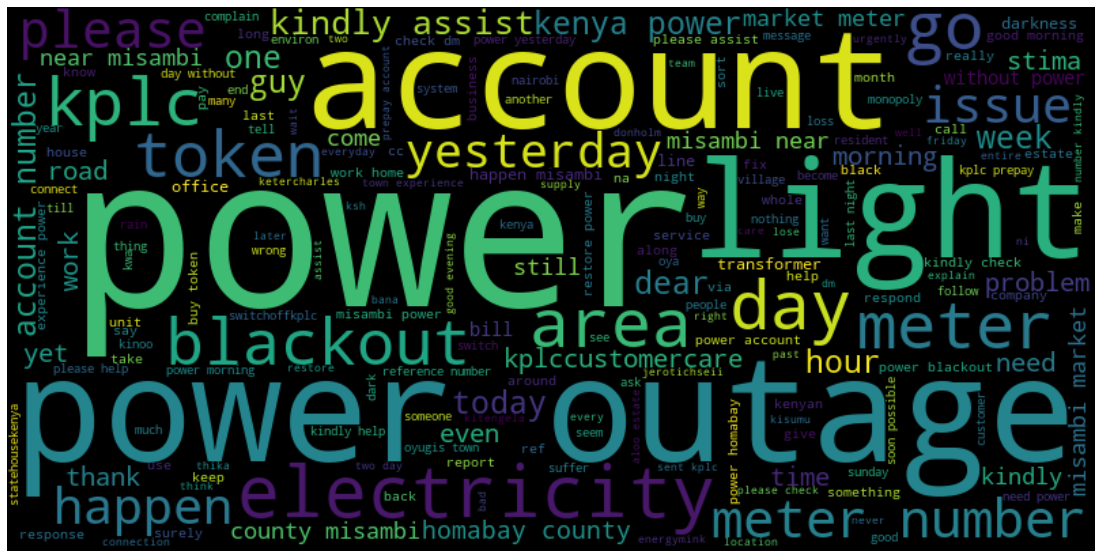

In [187]:
#let's see a word cloud of the most common terms
from wordcloud import WordCloud, ImageColorGenerator

text = df_english['lemmatized_joined'].tolist() 


text = ' '.join(text)


wordcloud = WordCloud(collocations=True,width=800, height=400).generate(text)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

### From the word cloud we realize that some of the words are repeated many times and is worth investigation to see whether it is a sign of dirty data.

In [188]:
#checking the most common words

fig =px.bar(get_top_n_words(df_english['lemmatized_joined'],1,50),x='words',y='count')
fig.show()

In [189]:
mostCommon = get_top_n_words(df_english['lemmatized_joined'],1,150)
indexes = []
for word in mostCommon['words']:
  sentences = df_english[df_english['lemmatized_joined'].str.contains(word)]
  if(sentences['handle'].nunique()/len(sentences) * 100 < 10):
    users = sentences['handle'].unique();
    for user in users:
      indexes += (df_english[df_english['lemmatized_joined'].str.contains(word) & df_english['handle'].str.contains(user)][1:].index.tolist())
indexes = list(dict.fromkeys(indexes))
df_english.drop(indexes,inplace=True)


In [190]:
fig =px.bar(get_top_n_words(df_english['lemmatized_joined'],1,50),x='words',y='count')
fig.show()

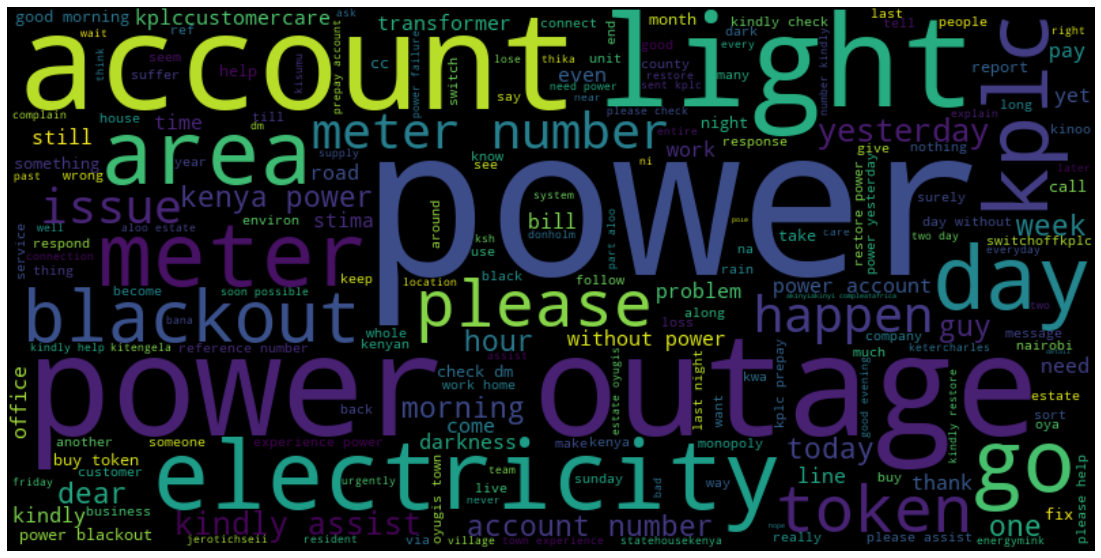

In [191]:
text = df_english['lemmatized_joined'].tolist() 


text = ' '.join(text)


wordcloud = WordCloud(collocations=True,width=800, height=400).generate(text)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

### Lets do some topic modeling on this data to check whether we could be able to categorize the tweets.

### We will start by trying LSA technique to see if we get sensible topics

In [192]:
vectorizer = TfidfVectorizer(
    max_df=0.8,
    ngram_range=(1,3),
    stop_words='english',
    max_features=100
    )

vectors = vectorizer.fit_transform(df_english['lemmatized_joined'])

In [193]:
lsa = TruncatedSVD(n_components=2,n_iter=1000)

lsa.fit(vectors)

TruncatedSVD(n_iter=1000)

In [194]:
vocabulary = vectorizer.get_feature_names_out()

for i, vect in enumerate(lsa.components_):
  voc_vect = zip(vocabulary,vect)
  sorted_voc = sorted(voc_vect,key = lambda x:x[1], reverse=True)[:15]
  print("Topic %d" % i)
  for term in sorted_voc:
    print(term[0])
  print(" ")

Topic 0
power
account
outage
power outage
kindly
area
day
meter
number
assist
blackout
yesterday
light
meter number
power account
 
Topic 1
light
token
meter
kindly
number
account
electricity
assist
kindly assist
meter number
kplc
blackout
morning
account number
buy
 


In [195]:
cluster_model = KMeans(n_clusters=2, max_iter=100,n_init=4)

cluster_model.fit(vectors)

clusters = cluster_model.predict(vectors)

pca = PCA(n_components=2)

scatter_plots = pca.fit_transform(vectors.toarray())

colors = ["topic 1","topic 2","topic 3"]

x_axis = [o[0] for o in scatter_plots]
y_axis = [o[1] for o in scatter_plots]

fig = px.scatter(x= x_axis, y = y_axis, color = [colors[d] for d in clusters])
fig.show()

In [196]:
clustersProb = cluster_model.cluster_centers_.argsort()[:,::-1]

for index_cluster in range(2):
  print("Topic %d" % index_cluster)
  for ind in clustersProb[index_cluster,:15]:
    print(vocabulary[ind])
  print(" ")

Topic 0
light
electricity
token
blackout
account
kplc
kindly
stima
meter
day
number
area
morning
issue
check
 
Topic 1
power
outage
power outage
account
area
day
kindly
number
meter
kenya
power account
assist
kenya power
yesterday
restore
 


### From LSA we can clearly tell that we have 2 main categories for tweet queries:

1. Power outage.

2. Token Enquries.

### Lets now do an analysis using LDA to see if we are going to get more insightful data. 

In [197]:

textTokenized = df_english['lemmatized_joined'].apply(word_tokenize)
# Build the bigram and trigram models
bigram = gensim.models.Phrases(textTokenized, min_count=5, threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

textP = make_bigrams(textTokenized)

id2word = corpora.Dictionary(textP)

corpus = [id2word.doc2bow(text) for text in textP]

tfidf = TfidfModel(corpus,id2word)

max_df = 0.03
words = []
words_missing = []
for i in range (0, len(corpus)):
  bow = corpus[i]
  low_value_words = []
  tfidf_ids = [id for id, value in tfidf[bow]]
  bow_ids = [id for id,value in bow]
  low_value_words = [id for id, value in tfidf[bow] if value < max_df]
  drops = low_value_words + words_missing
  for item in drops:
    words.append(id2word[item])
  words_missing = [id for id in bow_ids if id not in tfidf_ids]
  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing]
  corpus[i] = new_bow


In [198]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [199]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus,id2word,mds="mmds", R=30)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.051016  0.161045       1        1  59.411323
1      0.051016 -0.161045       2        1  40.588677, topic_info=            Term         Freq        Total Category  logprob  loglift
30         power  1109.000000  1109.000000  Default  30.0000  30.0000
49         since   409.000000   409.000000  Default  29.0000  29.0000
117         kplc   234.000000   234.000000  Default  28.0000  28.0000
505        token   201.000000   201.000000  Default  27.0000  27.0000
329       kindly   322.000000   322.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
12            go    62.661278   155.952922   Topic2  -5.3060  -0.0101
9    electricity    55.891116   171.330476   Topic2  -5.4203  -0.2185
28           one    46.981227    95.040447   Topic2  -5.5940   0.1971
281         need    42.279675   101.956447   Topic2  -5.6994   0.0214
50         still    39.285322    90.897273   Topic2  -5.7729   0.0628

[120 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
40        1  0.981811    account
40        2  0.018727    account
72        1  0.999138       area
72        2  0.003828       area
60        1  0.988034     around
...     ...       ...        ...
297       2  0.664453       year
326       1  0.994528  yesterday
326       2  0.005587  yesterday
215       1  0.011944        yet
215       2  0.991330        yet

[159 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [200]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=textTokenized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.676100935784568

Coherence Score:  0.27851950452835517
